<a href="https://colab.research.google.com/github/bcaffo/ds4ph-bme/blob/master/notebooks/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this exercise, we'll build an autoencoder to model cryptopunks. You might have heard of the recent NFT (non-fungible token) craze. Cryptopunks are example NFT assets that one can buy. As of this writing, the cheapest Cryptopunk is worth over $40,000 dollars. The punks each have attributes, like a mustache or hairstyle. We'll train a conv net to classify punks by attributes. First we'll need to download all of the cryptopunks, which are in a giant single image file. Then separate them into the individual punks. (There's probably an easier way to do this, but this wasn't that hard.) Then we'll build a tensorflow model of the punks.

In [ ]:
import urllib.request
import PIL
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses

Import the image of all of the cryptopunks.

In [ ]:

imgURL = "https://raw.githubusercontent.com/larvalabs/cryptopunks/master/punks.png"
urllib.request.urlretrieve(imgURL, "cryptoPunksAll.jpg")


('cryptoPunksAll.jpg', <http.client.HTTPMessage at 0x7f3ad6e05610>)

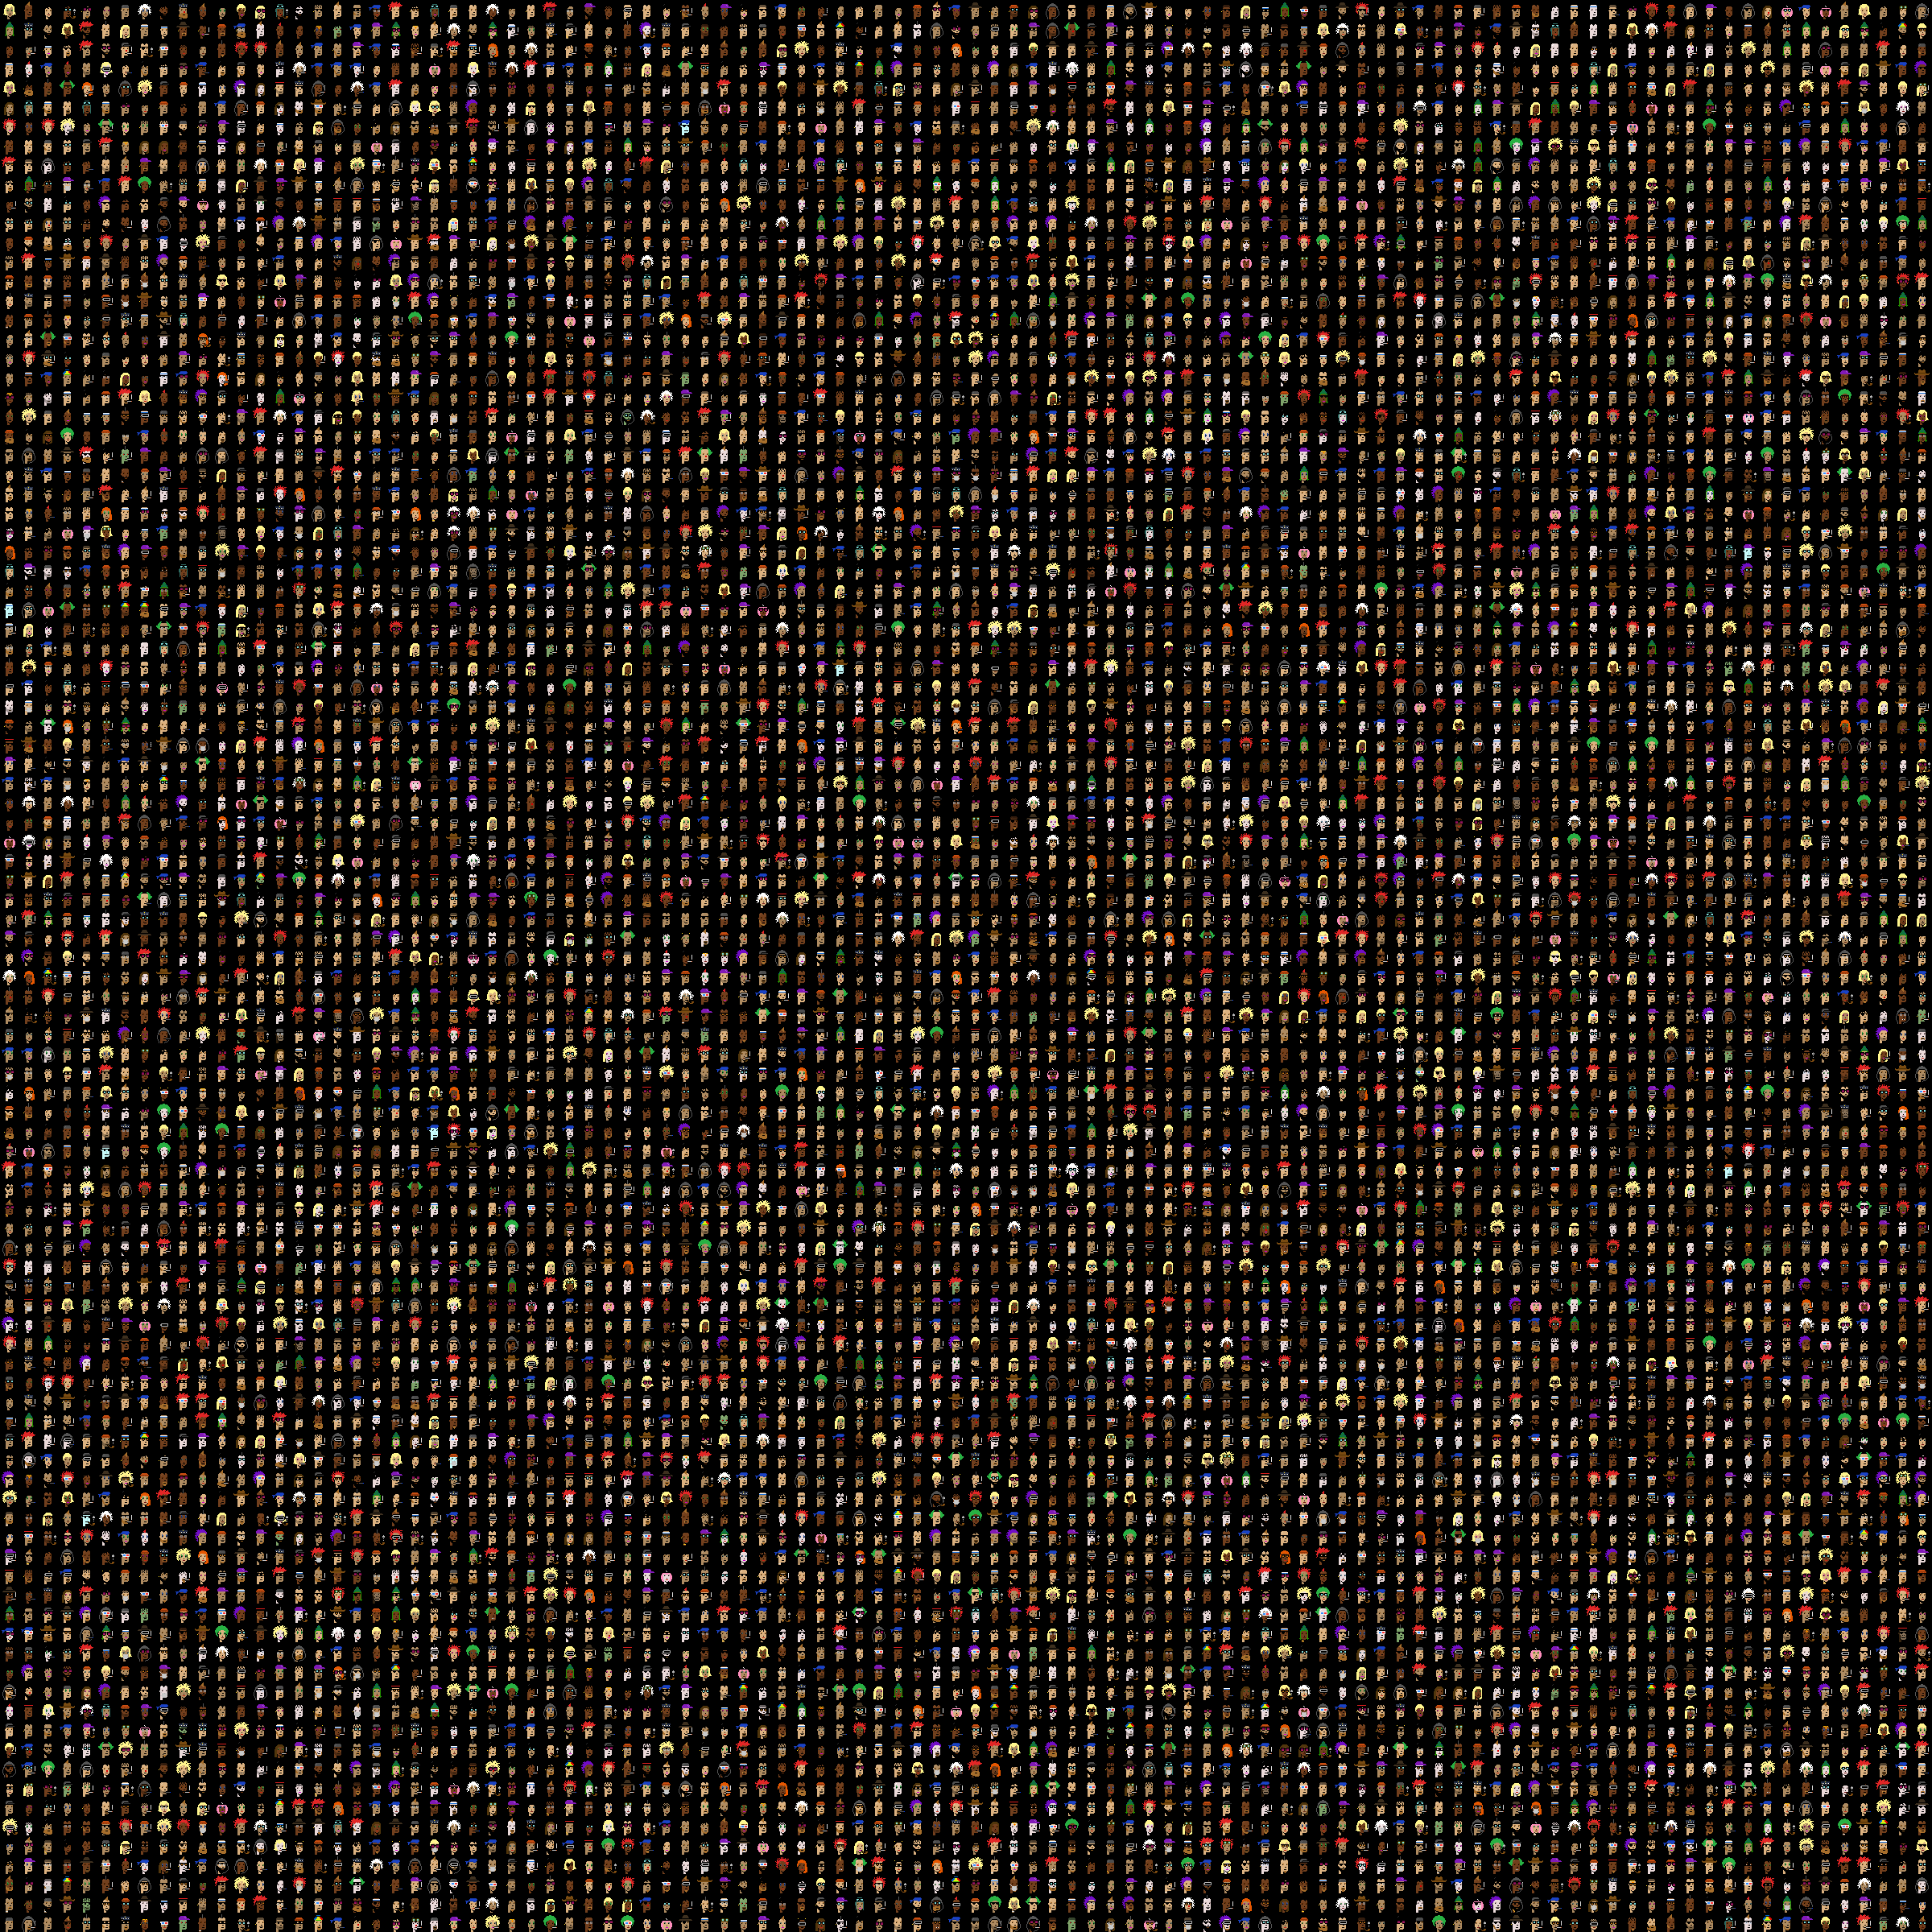

In [ ]:
img = PIL.Image.open("cryptoPunksAll.jpg").convert("RGB")
img

It looks like there's 100x100=10,000 crypto punks each one being a 24x24 (x3 color channels) image. 

In [ ]:
img.size

(2400, 2400)

Convert to a numpy array and visualize some. Here's punk 0.

([], <a list of 0 Text major ticklabel objects>)

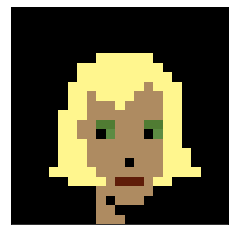

In [ ]:
imgArray = np.asarray(img)
plt.imshow(imgArray[0 : 23, 0 : 23, :])
plt.xticks([])
plt.yticks([])


Here's punks 0 : 24. You can double check that the reference image is filling by rows associated with the punk's index by looking at links like these (change the final number which is the punk's index):

*   https://www.larvalabs.com/cryptopunks/details/0
*   https://www.larvalabs.com/cryptopunks/details/1



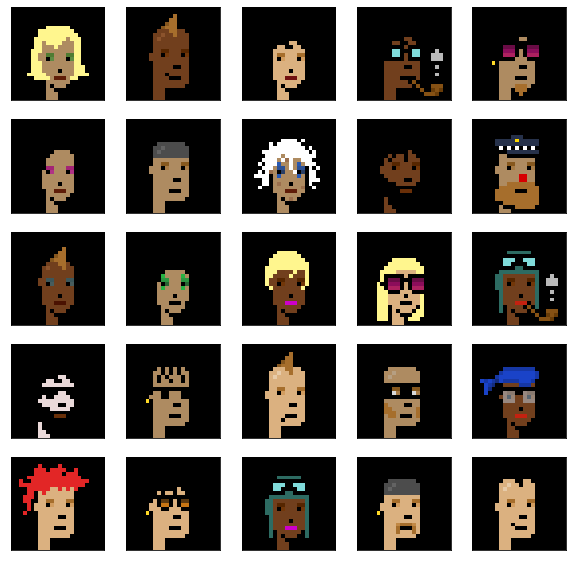

In [ ]:
#Plot out the first 25 punks
plt.figure(figsize=(10,10))
for i in range(25): 
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  a, b = (24 * i), (24 * (i + 1))
  plt.imshow(imgArray[0 : 24, a : b, :])

Reorder the array. I couldn't get reshape to do this right, but I think this is a one-line command waiting to happen. See if you can figure out a better way. All images are 24x24x3 and there's 10,000 punks. (Supposedly, there will only ever be 10k punks.)


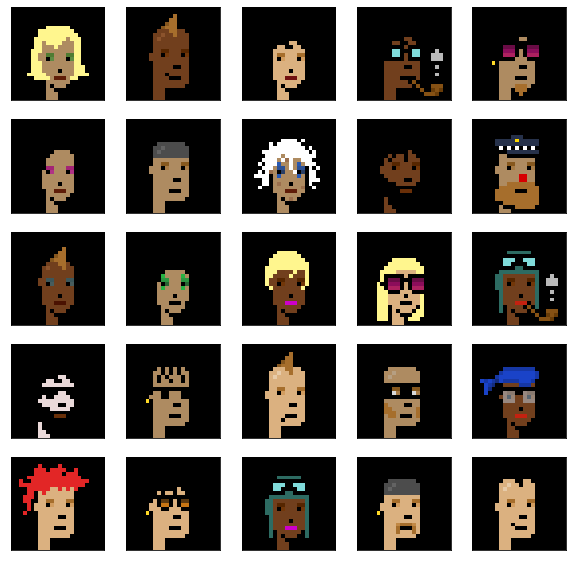

In [ ]:
finalArray = np.empty((10000, 24, 24, 3))
for i in range(100):
  for j in range(100):
    a, b = 24 * i, 24 * (i + 1)  
    c, d = 24 * j, 24 * (j + 1) 
    idx = j + i * (100)
    finalArray[idx,:,:,:] = imgArray[a:b,c:d,:]

## double check with above
## apparently the .astype('uint8') is needed to display correctly now
plt.figure(figsize=(10,10))
for i in range(25): 
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(finalArray[i,:,:,:].astype('uint8'))

Let's normalize our array and split it into testing and training data.

In [ ]:
n = finalArray.shape[0]
trainFraction = .75
sample = np.random.uniform(size = n) < trainFraction
x_train = finalArray[ sample, :, :, :] / 255
x_test =  finalArray[~sample, :, :, :] / 255
[x_train.shape, x_test.shape]

[(7538, 24, 24, 3), (2462, 24, 24, 3)]

Now let's create our encoder/decoder. Here we're going to use a simple approach for just flattening the images, one dense layer, they decoding.

In [ ]:
autoED = tf.keras.Sequential()
autoED.add(layers.InputLayer(input_shape=(24, 24, 3)))
autoED.add(layers.Flatten())
autoED.add(layers.Dense(64, activation='relu'))
autoED.add(layers.Dense(1728, activation='sigmoid'))
autoED.add(layers.Reshape(target_shape = (24, 24, 3)))
autoED.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoED.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                110656    
_________________________________________________________________
dense_3 (Dense)              (None, 1728)              112320    
_________________________________________________________________
reshape_1 (Reshape)          (None, 24, 24, 3)         0         
Total params: 222,976
Trainable params: 222,976
Non-trainable params: 0
_________________________________________________________________


Here's what you get if you run some of the test images through the initialized weights.

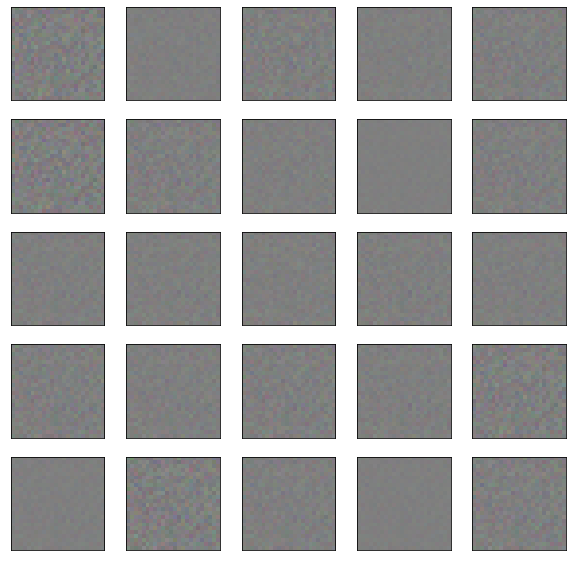

In [ ]:
test = autoED(x_test[0 : 25,:,:,:])
plt.figure(figsize=(10,10))
for i in range(25): 
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test[i,:,:,:])

OK, now let's update the weights.

In [ ]:
autoED.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/10
236/236 [==============================] - 2s 7ms/step - loss: 0.0634 - val_loss: 0.0174
Epoch 2/10
236/236 [==============================] - 1s 6ms/step - loss: 0.0154 - val_loss: 0.0105
Epoch 3/10
236/236 [==============================] - 1s 6ms/step - loss: 0.0095 - val_loss: 0.0075
Epoch 4/10
236/236 [==============================] - 1s 5ms/step - loss: 0.0070 - val_loss: 0.0059
Epoch 5/10
236/236 [==============================] - 1s 5ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 6/10
236/236 [==============================] - 1s 6ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 7/10
236/236 [==============================] - 1s 5ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 8/10
236/236 [==============================] - 1s 5ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 9/10
236/236 [==============================] - 1s 5ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/10
236/236 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 0.0023

Let's revisualize the first 25 test images with the new encoder/decoder.

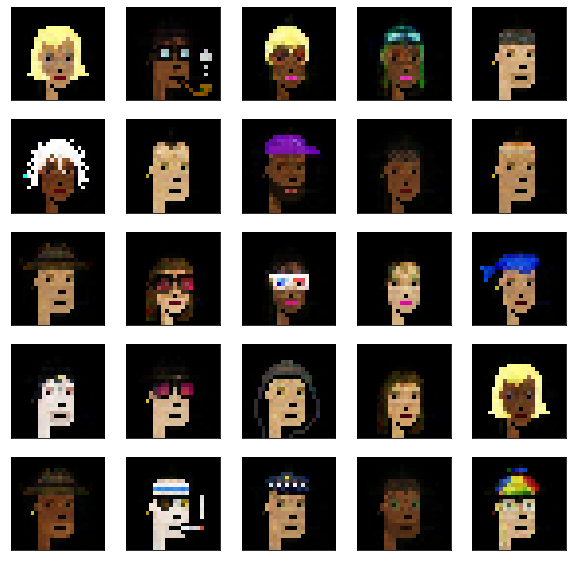

In [ ]:
test = autoED(x_test[0 : 25,:,:,:])
plt.figure(figsize=(10,10))
for i in range(25): 
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test[i,:,:,:])

Let's look at the original test images for comparison.

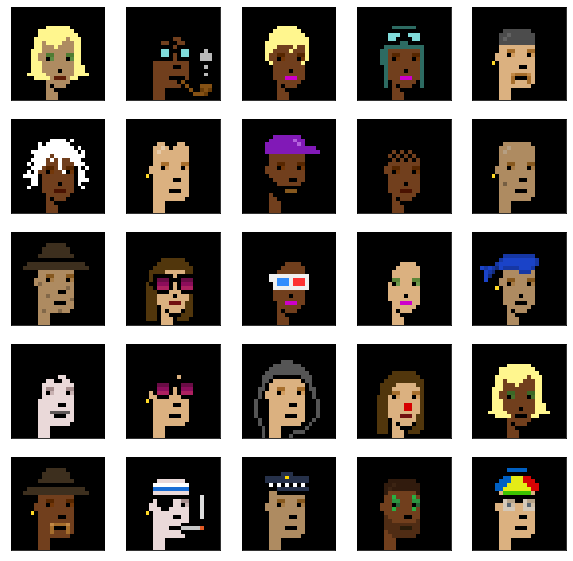

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25): 
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[i,:,:,:])

So now, we can store crypto punks as 64 numbers obtained from their original 1,728 numbers.